In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
# for data load
import os
import pandas as pd
from glob import glob
import segmentation_models_pytorch as smp
import tensorflow as tf
from segmentation_models_pytorch.losses import DiceLoss
import torch.nn as nn
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

# for reading and processing images
import imageio
from PIL import Image

# for visualizations
import matplotlib.pyplot as plt

import numpy as np # for using np arrays

# for bulding and running deep learning model
from sklearn.metrics import precision_score, recall_score, jaccard_score
from scipy.spatial.distance import directed_hausdorff
from sklearn.model_selection import train_test_split
from google.colab import files



In [5]:
#upload kaggle token and download dataset
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation
!unzip lgg-mri-segmentation.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: /content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: /content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: /content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: /content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: /content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: /content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: /content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: /conte

In [6]:
def LoadData (path1, path2):
    """
    Looks for relevant filenames in the shared path
    Returns 2 lists for original and masked files respectively

    """
    # Read the images folder like a list

    # Make a list for images and masks filenames
    orig_img = []
    mask_img = []
    for file in path1:
        orig_img.append(file)
    for file in path2:
        mask_img.append(file)

    # Sort the lists to get both of them in same order (the dataset has exactly the same name for images and corresponding masks)
    orig_img.sort()
    mask_img.sort()

    return orig_img, mask_img



In [7]:
def PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2):
    """
    Processes the images and mask present in the shared list and path
    Returns a NumPy dataset with images as 3-D arrays of desired size
    Please note the masks in this dataset have only one channel
    """
    # Pull the relevant dimensions for image and mask
    m = len(img)                     # number of images
    i_h,i_w,i_c = target_shape_img   # pull height, width, and channels of image
    m_h,m_w,m_c = target_shape_mask  # pull height, width, and channels of mask

    # Define X and Y as number of images along with shape of one image
    X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32)
    y = np.zeros((m,m_h,m_w,m_c), dtype=np.float32)
    i = 0
    # Resize images and masks
    for file in img:
        # convert image into an array of desired shape (3 channels)
        index = img.index(file)
        path = os.path.join(path1[i], file)
        single_img = Image.open(path).convert('RGB')
        single_img = single_img.resize((i_h,i_w))
        single_img = np.reshape(single_img,(i_h,i_w,i_c))
        single_img = single_img/255.
        X[index] = single_img

        # convert mask into an array of desired shape (1 channel)
        single_mask_ind = mask[index]
        path = os.path.join(path2[i], single_mask_ind)
        single_mask = Image.open(path)
        single_mask = single_mask.resize((m_h, m_w))
        single_mask = np.array(single_mask,dtype=np.float32)
        # Ensure classes start from 0 (if necessary)
        single_mask[single_mask == 255] = 1  # Convert 255 to background (0)
        single_mask[single_mask > 1] = 1  # Ensure only two classes: 0 (background) and 1 (tumor)

        # Reshape and store in y
        single_mask = np.reshape(single_mask, (m_h, m_w, m_c))
        y[index] = single_mask
        i += 1
    return X, y

In [8]:
def compute_metrics(y_true, y_pred):
    y_pred_bin = (y_pred > 0.5).astype(np.uint8)  # Convert to binary mask

    dice = dice_coefficient(y_true, y_pred_bin).numpy()
    iou_score = iou(y_true, y_pred_bin).numpy()

    precision = precision_score(y_true.flatten(), y_pred_bin.flatten(), zero_division=1)
    recall = recall_score(y_true.flatten(), y_pred_bin.flatten(), zero_division=1)

    hausdorff_dist = directed_hausdorff(y_true.squeeze(), y_pred_bin.squeeze())[0]

    return {
        'Dice Coefficient': dice,
        'IoU': iou_score,
        'Precision': precision,
        'Recall': recall,
        'Hausdorff Distance': hausdorff_dist
    }


In [9]:
def get_file_row(path):
    """Produces ID of a patient, image and mask filenames from a particular path"""
    path_no_ext, ext = os.path.splitext(path)
    filename = os.path.basename(path)

    patient_id = '_'.join(filename.split('_')[:3]) # Patient ID in the csv file consists of 3 first filename segments

    return [patient_id, path, f'{path_no_ext}_mask{ext}']

files_dir = '/content/dataset/lgg-mri-segmentation/kaggle_3m'
file_paths = glob(f'{files_dir}/*/*[0-9].tif')
train_df = pd.DataFrame((get_file_row(filename) for filename in file_paths), columns=['Patient', 'image_filename', 'mask_filename'])

def is_valid_mask(mask_path, threshold=0.03):
    """Returns True if at least `threshold` of pixels are non-black."""
    mask = Image.open(mask_path).convert('L')
    mask_array = np.array(mask)
    non_black_ratio = np.count_nonzero(mask_array) / mask_array.size
    return non_black_ratio >= threshold

# Filter out rows with masks that are too empty (>=97% black)
filtered_df = train_df[train_df['mask_filename'].apply(is_valid_mask)].reset_index(drop=True)

print(f"Filtered dataset size: {len(filtered_df)} / {len(train_df)}")
filtered_df


Filtered dataset size: 550 / 3929


,Patient,image_filename,mask_filename
0,TCGA_CS_6666,/content/dataset/lgg-mri-segmentation/kaggle_3...,/content/dataset/lgg-mri-segmentation/kaggle_3...
1,TCGA_CS_6666,/content/dataset/lgg-mri-segmentation/kaggle_3...,/content/dataset/lgg-mri-segmentation/kaggle_3...
2,TCGA_CS_6666,/content/dataset/lgg-mri-segmentation/kaggle_3...,/content/dataset/lgg-mri-segmentation/kaggle_3...
3,TCGA_CS_6666,/content/dataset/lgg-mri-segmentation/kaggle_3...,/content/dataset/lgg-mri-segmentation/kaggle_3...
4,TCGA_CS_6666,/content/dataset/lgg-mri-segmentation/kaggle_3...,/content/dataset/lgg-mri-segmentation/kaggle_3...
...,...,...,...
545,TCGA_DU_6408,/content/dataset/lgg-mri-segmentation/kaggle_3...,/content/dataset/lgg-mri-segmentation/kaggle_3...
546,TCGA_DU_6408,/content/dataset/lgg-mri-segmentation/kaggle_3...,/content/dataset/lgg-mri-segmentation/kaggle_3...
547,TCGA_DU_6408,/content/dataset/lgg-mri-segmentation/kaggle_3...,/content/dataset/lgg-mri-segmentation/kaggle_3...
548,TCGA_DU_6408,/content/dataset/lgg-mri-segmentation/kaggle_3...,/content/dataset/lgg-mri-segmentation/kaggle_3...


<ipython-input-10-b619efc5a350>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_view  = imageio.imread(path1[i])
<ipython-input-10-b619efc5a350>:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask_view = imageio.imread(path2[i])


(256, 256, 3)
(256, 256)


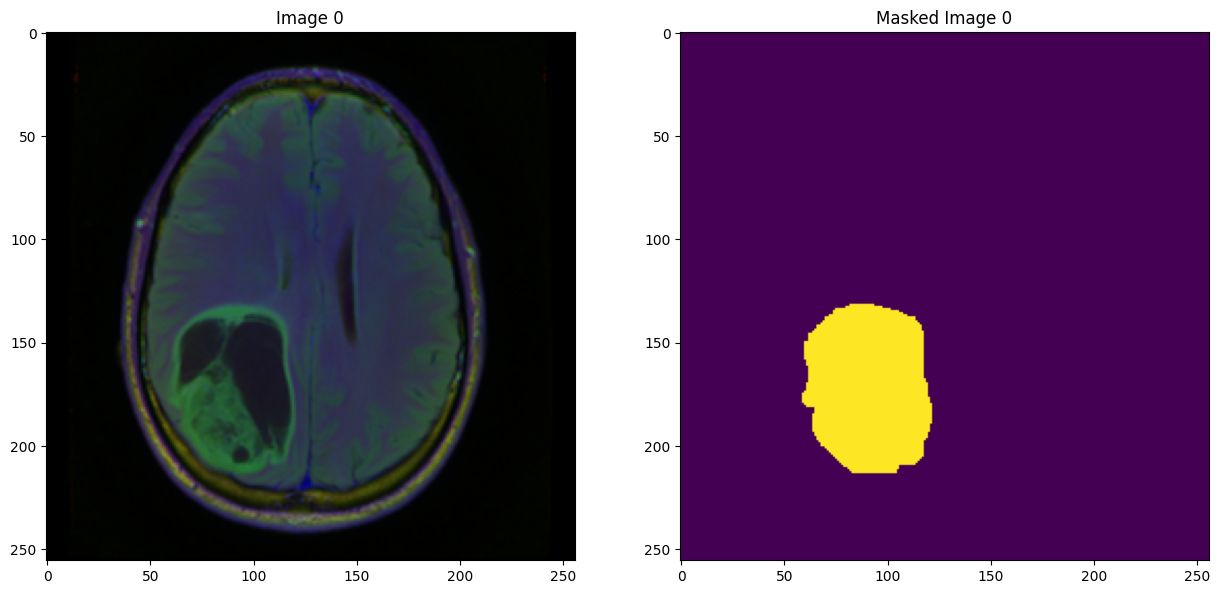

In [10]:
""" Load Train Set and view some examples """
# Call the apt function
path1 = filtered_df["image_filename"].tolist()
path2 = filtered_df["mask_filename"].tolist()
img, mask = LoadData (path1, path2)


# View an example of image and corresponding mask
show_images = 1
for i in range(show_images):
    img_view  = imageio.imread(path1[i])
    mask_view = imageio.imread(path2[i])
    print(img_view.shape)
    print(mask_view.shape)
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(img_view)
    arr[0].set_title('Image '+ str(i))
    arr[1].imshow(mask_view)
    arr[1].set_title('Masked Image '+ str(i))

X Shape: (550, 128, 128, 3)
Y shape: (550, 128, 128, 1)
[0. 1.]


Text(0.5, 1.0, 'Processed Masked Image')

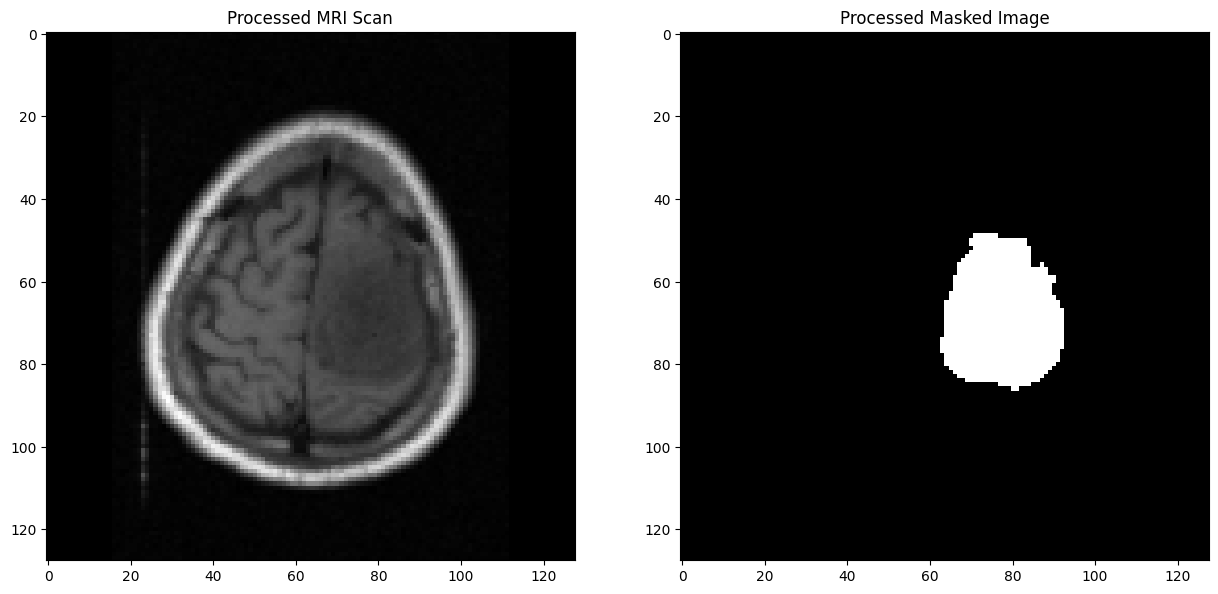

In [11]:
# Define the desired shape
target_shape_img = [128, 128, 3]
target_shape_mask = [128, 128, 1]

# Process data using apt helper function
X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2)

# QC the shape of output and classes in output dataset
print("X Shape:", X.shape)
print("Y shape:", y.shape)
# There are 2 classes : background, tumor
print(np.unique(y))

# Visualize the output
image_index = 5
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(X[image_index, :, :, 0], cmap='gray')  # Show MRI image in grayscale
arr[0].set_title('Processed MRI Scan')

arr[1].imshow(y[image_index, :, :, 0], cmap='gray')  # Show mask in grayscale
arr[1].set_title('Processed Masked Image')


In [12]:
# Use scikit-learn's function to split the dataset
# Here, I have used 20% data as test/valid set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)

In [35]:
# First, you need a custom Dataset class
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths):
        self.image_paths = path1
        self.mask_paths = path2

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
      image_path = self.image_paths[idx]
      mask_path = self.mask_paths[idx]

      image = Image.open(image_path)
      image = np.array(image)

      mask = Image.open(mask_path)
      mask = np.array(mask)

      #Arrays to tensors
      image = torch.tensor(image, dtype=torch.float32)
      mask = mask / 255.0
      mask = torch.tensor(mask, dtype=torch.float32)
      if len(image.shape) == 3:  # RGB
        image = image.permute(2, 0, 1)  # [H, W, C] -> [C, H, W]
      else:  # Grayscale
        image = image.unsqueeze(0)  # Add channel dim: [1, H, W]

      # Mask processing
      if len(mask.shape) == 2:  # [H, W]
        mask = mask.unsqueeze(0)

      return image, mask

# Then create train and validation datasets
train_dataset = SegmentationDataset(
    X_train,
    y_train,
)

val_dataset = SegmentationDataset(
    X_valid,
    y_valid
)

# Finally create the DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2
)

In [14]:
pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 48.5 MB/s eta 0:00:00


In [36]:
from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score

In [37]:
# Training function with metric display
from torch.optim.lr_scheduler import ReduceLROnPlateau

iou_metric = BinaryJaccardIndex(threshold=0.5)
f1_metric = BinaryF1Score(threshold=0.5)

def train_model(model, train_loader, val_loader, optimizer, loss_fn, num_epochs):
    # Store metrics history
    history = {
        'train_loss': [],
        'val_loss': [],
        'iou_score': [],
        'f1_score': []
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_losses = []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            inputs, targets = batch

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = loss_fn(outputs, targets)
            train_losses.append(loss.item())

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()


        # Validation phase
        model.eval()
        val_losses = []
        iou_scores = []
        f1_scores = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]"):
                inputs, targets = batch

                # Forward pass
                outputs = model(inputs)

                # Calculate loss
                loss = loss_fn(outputs, targets)
                val_losses.append(loss.item())

                # Calculate metrics - replace with your actual metric functions
                # Using smp metrics as an example
                outputs_binary = (outputs > 0.5).float()  # Threshold predictions
                iou = iou_metric(outputs, targets)
                f1 = f1_metric(outputs, targets)

                iou_scores.append(iou.item())
                f1_scores.append(f1.item())

        # Calculate epoch metrics
        avg_train_loss = np.mean(train_losses)
        avg_val_loss = np.mean(val_losses)
        avg_iou = np.mean(iou_scores)
        avg_f1 = np.mean(f1_scores)

        # Store metrics
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['iou_score'].append(avg_iou)
        history['f1_score'].append(avg_f1)

        # Print epoch results
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        print(f"IoU Score: {avg_iou:.4f} | F1 Score: {avg_f1:.4f}")
        print("-" * 50)

        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    return history

In [50]:
import matplotlib.pyplot as plt
import numpy as np

def show_tensor_image(tensor, title="", is_mask=False):
    # Convert tensor to NumPy for display
    tensor = tensor.squeeze().cpu().numpy()  # Remove any singleton dimensions

    # If it's a mask, we use a different display method (usually binary)
    if is_mask:
        plt.imshow(tensor, cmap='gray')  # Show in grayscale
    else:
        # For images, ensure the tensor is in [H, W, C] format (matplotlib expects channel last)
        if len(tensor.shape) == 3:  # If it's a 3D tensor (e.g., RGB)
            tensor = np.transpose(tensor, (1, 2, 0))  # Change from [C, H, W] to [H, W, C]
        plt.imshow(tensor)

    plt.title(title)
    plt.axis('off')  # Hide axes for cleaner display
    plt.show()

In [39]:
model = smp.DeepLabV3(backbone_name='resnet34', encoder_weights='imagenet', classes=1, activation='sigmoid')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = smp.losses.DiceLoss(mode="binary")

In [40]:
#Train model
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    num_epochs=10
)


Epoch 1/10 [Valid]: 100%|██████████| 35/35 [00:54<00:00,  1.57s/it]


Epoch 1/10
Train Loss: 0.8817 | Val Loss: 0.8776
IoU Score: 0.2582 | F1 Score: 0.4087
--------------------------------------------------


Epoch 2/10 [Valid]: 100%|██████████| 35/35 [00:55<00:00,  1.58s/it]


Epoch 2/10
Train Loss: 0.8750 | Val Loss: 0.8726
IoU Score: 0.4497 | F1 Score: 0.6190
--------------------------------------------------


Epoch 3/10 [Valid]: 100%|██████████| 35/35 [00:55<00:00,  1.58s/it]


Epoch 3/10
Train Loss: 0.8717 | Val Loss: 0.8700
IoU Score: 0.6468 | F1 Score: 0.7841
--------------------------------------------------


Epoch 4/10 [Valid]: 100%|██████████| 35/35 [00:55<00:00,  1.57s/it]


Epoch 4/10
Train Loss: 0.8695 | Val Loss: 0.8695
IoU Score: 0.6459 | F1 Score: 0.7836
--------------------------------------------------


Epoch 5/10 [Valid]: 100%|██████████| 35/35 [00:55<00:00,  1.59s/it]


Epoch 5/10
Train Loss: 0.8694 | Val Loss: 0.8683
IoU Score: 0.6284 | F1 Score: 0.7705
--------------------------------------------------


Epoch 6/10 [Valid]: 100%|██████████| 35/35 [00:55<00:00,  1.60s/it]


Epoch 6/10
Train Loss: 0.8679 | Val Loss: 0.8674
IoU Score: 0.6587 | F1 Score: 0.7934
--------------------------------------------------


Epoch 7/10 [Valid]: 100%|██████████| 35/35 [00:56<00:00,  1.61s/it]


Epoch 7/10
Train Loss: 0.8679 | Val Loss: 0.8677
IoU Score: 0.6354 | F1 Score: 0.7759
--------------------------------------------------


Epoch 8/10 [Valid]: 100%|██████████| 35/35 [00:55<00:00,  1.59s/it]


Epoch 8/10
Train Loss: 0.8675 | Val Loss: 0.8674
IoU Score: 0.7116 | F1 Score: 0.8306
--------------------------------------------------


Epoch 9/10 [Valid]: 100%|██████████| 35/35 [00:55<00:00,  1.57s/it]


Epoch 9/10
Train Loss: 0.8670 | Val Loss: 0.8672
IoU Score: 0.7048 | F1 Score: 0.8259
--------------------------------------------------


Epoch 10/10 [Valid]: 100%|██████████| 35/35 [00:54<00:00,  1.57s/it]

Epoch 10/10
Train Loss: 0.8671 | Val Loss: 0.8669
IoU Score: 0.7707 | F1 Score: 0.8698
--------------------------------------------------


In [41]:
def evaluate_model(model, val_loader, loss_fn):
    model.eval()  # Set the model to evaluation mode
    val_losses = []
    iou_scores = []
    f1_scores = []

    with torch.no_grad():  # No need to track gradients during evaluation
        for batch in val_loader:
            inputs, targets = batch

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = loss_fn(outputs, targets)
            val_losses.append(loss.item())

            # Calculate metrics - using smp metrics as an example
            outputs_binary = (outputs > 0.5).float()  # Threshold predictions
            iou = smp.metrics.iou_score(outputs_binary, targets)
            f1 = smp.metrics.f1_score(outputs_binary, targets)

            iou_scores.append(iou.item())
            f1_scores.append(f1.item())

    # Calculate average metrics
    avg_val_loss = sum(val_losses) / len(val_losses)
    avg_iou = sum(iou_scores) / len(iou_scores)
    avg_f1 = sum(f1_scores) / len(f1_scores)

    # Return results
    results = {
        'val_loss': avg_val_loss,
        'iou_score': avg_iou,
        'f1_score': avg_f1
    }

    return results

TypeError: Invalid shape (3, 3, 256, 256) for image data

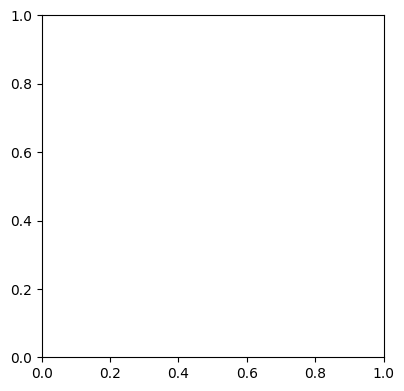

In [51]:
# Results of Validation Dataset
# Get a batch and make predictions
for batch in val_loader:
    images, masks = batch

    # Forward pass
    model.eval()
    with torch.no_grad():
      predictions = model(images)

    # Convert predictions to binary (if using a threshold)
    binary_preds = (predictions > 0.5).float()


    for index in images:
      index_show = str(index)
      index = torch.tensor([0, 2, 4], dtype=torch.long)
      image = images[index]
      mask = masks[index]
      pred = binary_preds[index]

      # Display
      plt.figure(figsize=(15, 5))

      plt.subplot(1, 3, 1)
      show_tensor_image(image, title="Input Image" + index_show)

      plt.subplot(1, 3, 2)
      show_tensor_image(mask, title="True Mask" + index_show, is_mask=True)

      plt.subplot(1, 3, 3)
      show_tensor_image(pred, title="Predicted Mask" + index_show, is_mask=True)

      break